# 基于图的模型

In [ ]:
'''
基于用户的协同过滤算法： 给用户推荐和他兴趣相似的其他用户喜欢的物品
    缺点：
        应用少，eg: 买过此产品的人还买了xx    
        因为随着用户增大，计算用户兴趣相似度矩阵越困难；
        UserCF很难对推荐结果做出解释。eg: a买了语文，数学，b买了语文，数学，勺子。不能因为兴趣相似，就把勺子推给a
        理论基础弱。基于统计。
        存储稠密矩阵大。存储空间O(M*M) M个用户


基于物品的协同过滤算法： 给用户推荐和他之前喜欢的物品相似的物品。
    缺点：
        理论基础弱。基于统计
        存储稠密矩阵大。存储空间O(N*N) N个物品
    优点：
        应用广，eg: 购买过《数据分析》推荐《机器学习》
        活跃用户对物品相似度的贡献应该小于不活跃的用户。eg：买了100万本的活跃用户，书涵盖领域多，两两书的相似度要低于只买了几本喜欢的书的文艺青年。
            活跃用户的100万的兴趣列表，会item-item为100w*100w的稠密矩阵，为了避免过于稠密，实际计算中忽略活跃用户的兴趣列表，不纳入相似度计算的数据集
        ItemCM利用 用户行为 对推荐结果做出解释。 eg:优酷 之前喜欢《天龙八部》，现在推荐《射雕英雄传》

隐语义模型 LFM (latent factor model) 
    缺点：
        很难实时推荐。
            因为每次训练需要扫描用户行为，才能计算隐类向量p和q，训练耗时，每天训练一次。 
            需要计算用户对所有物品的兴趣权重，然后排名，因此不能实时推荐。
            雅虎做了优化，我还没细看。
        没有很好的推荐解释。
    优点：
        理论基础强。机器学习方法，设定目标进行优化。
        存储空间比上面两张算法小。O(F(M*N))  .F个隐类，M个用户，N个物品
        在这个数据集上比基于邻域的两种算法都要好，当数据集稀疏时，LFM的性能会明显下降。

基于图的模型 graph-based model
    缺点：
        时间复杂度高。对每个用户进行推荐，都需要在整个用户物品二分图进行迭代，直到每个顶点PR值收敛。不能实时推荐。
            解决方法：减少迭代次数；从矩阵出发，重新设计算法。
'''

In [26]:
# 导入包
import random
import math
import numpy as np
import time
from tqdm import tqdm
from scipy.sparse import csc_matrix, linalg, eye
from copy import deepcopy

## 一. 通用函数定义

In [27]:
# 定义装饰器，监控运行时间
def timmer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        res = func(*args, **kwargs)
        stop_time = time.time()
        print('Func %s, run time: %s' % (func.__name__, stop_time - start_time))
        return res
    return wrapper

### 1. 数据处理相关
1. load data
2. split data

In [28]:
class Dataset():
    
    def __init__(self, fp):
        # fp: data file path
        self.data = self.loadData(fp)
    
    @timmer
    def loadData(self, fp):
        data = []
        for l in open(fp):
            data.append(tuple(map(int, l.strip().split('::')[:2])))
        return data
    
    @timmer
    def splitData(self, M, k, seed=1):
        '''
        :params: data, 加载的所有(user, item)数据条目
        :params: M, 划分的数目，最后需要取M折的平均
        :params: k, 本次是第几次划分，k~[0, M)
        :params: seed, random的种子数，对于不同的k应设置成一样的
        :return: train, test
        '''
        train, test = [], []
        random.seed(seed)
        for user, item in self.data:
            # 这里与书中的不一致，本人认为取M-1较为合理，因randint是左右都覆盖的
            if random.randint(0, M-1) == k:  
                test.append((user, item))
            else:
                train.append((user, item))

        # 处理成字典的形式，user->set(items)
        def convert_dict(data):
            data_dict = {}
            for user, item in data:
                if user not in data_dict:
                    data_dict[user] = set()
                data_dict[user].add(item)
            data_dict = {k: list(data_dict[k]) for k in data_dict}
            return data_dict

        return convert_dict(train), convert_dict(test)

### 2. 评价指标
1. Precision
2. Recall
3. Coverage
4. Popularity(Novelty)

In [29]:
class Metric():
    
    def __init__(self, train, test, GetRecommendation):
        '''
        :params: train, 训练数据
        :params: test, 测试数据
        :params: GetRecommendation, 为某个用户获取推荐物品的接口函数
        '''
        self.train = train
        self.test = test
        self.GetRecommendation = GetRecommendation
        self.recs = self.getRec()
        
    # 为test中的每个用户进行推荐
    def getRec(self):
        recs = {}
        for user in self.test:
            rank = self.GetRecommendation(user)
            recs[user] = rank
        return recs
        
    # 定义精确率指标计算方式
    def precision(self):
        all, hit = 0, 0
        for user in self.test:
            test_items = set(self.test[user])
            rank = self.recs[user]
            for item, score in rank:
                if item in test_items:
                    hit += 1
            all += len(rank)
        return round(hit / all * 100, 2)
    
    # 定义召回率指标计算方式
    def recall(self):
        all, hit = 0, 0
        for user in self.test:
            test_items = set(self.test[user])
            rank = self.recs[user]
            for item, score in rank:
                if item in test_items:
                    hit += 1
            all += len(test_items)
        return round(hit / all * 100, 2)
    
    # 定义覆盖率指标计算方式
    def coverage(self):
        all_item, recom_item = set(), set()
        for user in self.test:
            for item in self.train[user]:
                all_item.add(item)
            rank = self.recs[user]
            for item, score in rank:
                recom_item.add(item)
        return round(len(recom_item) / len(all_item) * 100, 2)
    
    # 定义新颖度指标计算方式
    def popularity(self):
        # 计算物品的流行度
        item_pop = {}
        for user in self.train:
            for item in self.train[user]:
                if item not in item_pop:
                    item_pop[item] = 0
                item_pop[item] += 1

        num, pop = 0, 0
        for user in self.test:
            rank = self.recs[user]
            for item, score in rank:
                # 取对数，防止因长尾问题带来的被流行物品所主导
                pop += math.log(1 + item_pop[item])
                num += 1
        return round(pop / num, 6)
    
    def eval(self):
        metric = {'Precision': self.precision(),
                  'Recall': self.recall(),
                  'Coverage': self.coverage(),
                  'Popularity': self.popularity()}
        print('Metric:', metric)
        return metric

## 二. PersonalRank算法实现

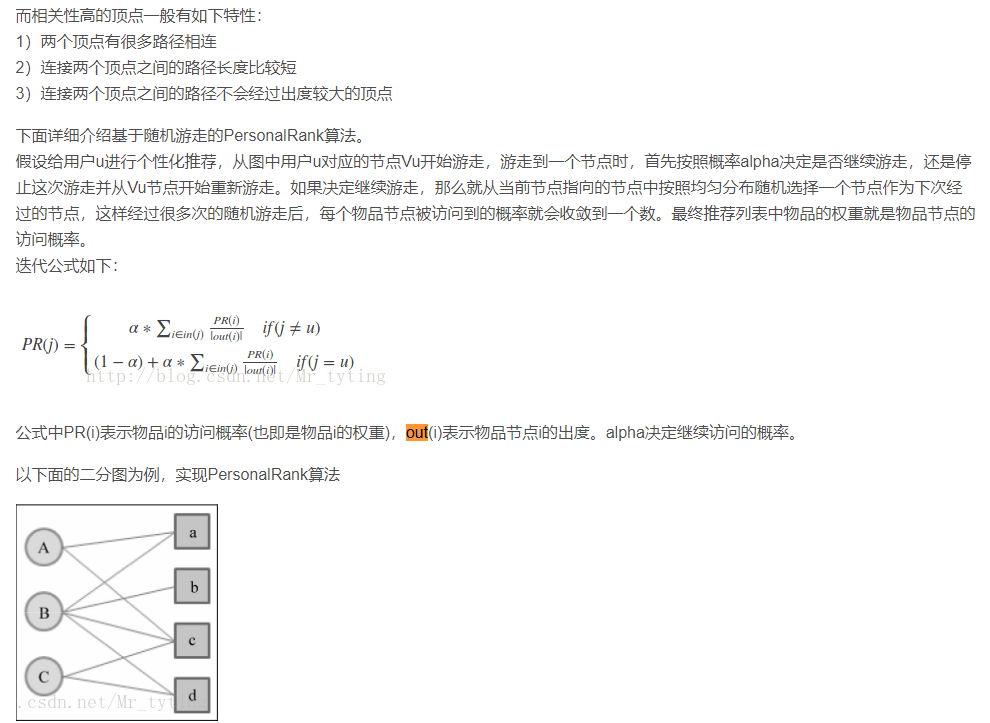

In [2]:
# 参考：https://blog.csdn.net/Mr_tyting/article/details/65638435?spm=1001.2014.3001.5502
#coding:utf-8
import time

def PersonalRank(G,alpha,root,max_depth):
    rank=dict()
    rank={x:0 for x in G.keys()} # 每个顶点的访问概率
    rank[root]=1
    #开始迭代
    begin=time.time()
    for k in range(max_depth):
        tmp={x:0 for x in G.keys()}
        #取出节点i和他的出边尾节点集合ri
        for i,ri in G.items():
            #取节点i的出边的尾节点j以及边E(i,j)的权重wij,边的权重都为1，归一化后就是1/len(ri)
            for j,wij in ri.items(): # wij代码中没有用到
                tmp[j]+=alpha*rank[i]/(1.0*len(ri))
        tmp[root]+=(1-alpha)
        rank=tmp
    end=time.time()
    print ('use_time',end-begin)
    lst=sorted(rank.items(),key=lambda x:x[1],reverse=True)
    for ele in lst:
        print ("%s:%.3f, \t" %(ele[0],ele[1]))

    return rank

if __name__=='__main__':
    alpha=0.8 # 决定继续访问的概率
    G = {'A': {'a': 1, 'c': 1},
         'B': {'a': 1, 'b': 1, 'c': 1, 'd': 1},
         'C': {'c': 1, 'd': 1},
         'a': {'A': 1, 'B': 1},
         'b': {'B': 1},  
         'c': {'A': 1, 'B': 1, 'C': 1},
         'd': {'B': 1, 'C': 1}}
    PersonalRank(G,alpha,'C',50)

use_time 0.00033020973205566406
C:0.314, 	
c:0.189, 	
B:0.166, 	
d:0.159, 	
A:0.076, 	
a:0.063, 	
b:0.033, 	


上面算法在时间复杂度上有个明显的缺陷，每次为每个用户推荐时，都需要在整个用户物品二分图上进行迭代，直到整个图上每个节点收敛。这一过程时间复杂度非常高，不仅无法提高实时推荐，甚至离线生产推荐结果也很耗时。

In [31]:
def test(train) :
    # 构建索引
    items = []  # 所有物品集合
    for user in train:
        items.extend(train[user])
    # id2item = list(set(items))
    id2item = list(items)
    users = {u: ind for ind, u in enumerate(train.keys())}          # user:ind
    items = {u: ind+len(users) for ind, u in enumerate(id2item)}    # item:ind+len(users)
    
    # 计算转移矩阵（注意！！！要按照出度进行归一化）
    # 计算item->user的倒排索引
    item_user = {}
    for user in train:
        for item in train[user]:
            if item not in item_user:
                item_user[item] = []
            item_user[item].append(user)
            
    data = [] # (用户出度数之和+物品出度数之和, )
    row = [] 
    col = []
    for user in train:
        for item in train[user]:
            data.append(1 / len(train[user])) # user的出度（item数量）的倒数，data.shape=(用户出度数之和, )
            row.append(users[user]) # user的ind序号, M矩阵的行索引
            col.append(items[item]) # item的ind+len(users)序号, M矩阵的列索引
    for item in item_user: 
        for user in item_user[item]:
            data.append(1 / len(item_user[item])) # 物品item的出度（user数量）, data.shape=(物品出度数之和, )
            row.append(items[item]) # item的ind+len(users)序号, M矩阵的行索引
            col.append(users[user]) # user的ind序号
            
    M = csc_matrix((data, (row, col)), shape=(len(data), len(data)))
    print('M=\n', M)
    print('M.toarray()=','\n', M.toarray())

if __name__=='__main__':
    train = {'A': ['a','b','c'],
            'B': ['e', 'f']}
    test(train)

M=
   (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 1)	1.0
  (6, 1)	1.0
  (0, 2)	0.3333333333333333
  (0, 3)	0.3333333333333333
  (0, 4)	0.3333333333333333
  (1, 5)	0.5
  (1, 6)	0.5
M.toarray()= 
 [[0.         0.         0.33333333 0.33333333 0.33333333 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.5
  0.5        0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        

In [32]:
def PersonalRank(train, alpha, N):
    '''
    :params: train, 训练数据
    :params: alpha, 继续随机游走的概率
    :params: N, 推荐TopN物品的个数
    :return: GetRecommendation, 获取推荐结果的接口
    ''' 
    
    # 构建索引
    items = []  # 所有物品集合
    for user in train:
        items.extend(train[user])
    # id2item = list(set(items))
    id2item = list(items)
    users = {u: ind for ind, u in enumerate(train.keys())}          # user:ind
    items = {u: ind+len(users) for ind, u in enumerate(id2item)}    # item:ind+len(users)
    
    # 计算转移矩阵（注意！！！要按照出度进行归一化）
    # 计算item->user的倒排索引
    item_user = {}
    for user in train:
        for item in train[user]:
            if item not in item_user:
                item_user[item] = []
            item_user[item].append(user)
            
    data = [] # (用户出度数之和+物品出度数之和, )
    row = [] 
    col = []
    for user in train:
        for item in train[user]:
            data.append(1 / len(train[user])) # user的出度（item数量）的倒数，data.shape=(用户出度数之和, )
            row.append(users[user]) # user的ind序号, M矩阵的行索引
            col.append(items[item]) # item的ind+len(users)序号, M矩阵的列索引
    for item in item_user: 
        for user in item_user[item]:
            data.append(1 / len(item_user[item])) # 物品item的出度（user数量）, data.shape=(物品出度数之和, )
            row.append(items[item]) # item的ind+len(users)序号, M矩阵的行索引
            col.append(users[user]) # user的ind序号
            
    M = csc_matrix((data, (row, col)), shape=(len(data), len(data)))
    
    # 获取接口函数，还没研究。
    def GetRecommendation(user):
        seen_items = set(train[user])
        # 解矩阵方程 r = (1-a)r0 + a(M.T)r
        r0 = [0] * len(data)
        r0[users[user]] = 1
        r0 = csc_matrix(r0)
        r = (1 - alpha) * linalg.inv(eye(len(data)) - alpha * M.T) * r0
        r = r.T.toarray()[0][len(users):]
        idx = np.argsort(-r)[:N]
        recs = [(id2item[ii], r[ii]) for ii in idx]
        return recs
    
    return GetRecommendation

## 三. PersonalRank实验
M=8, N=10, alpha=0.8

In [35]:
class Experiment():
    
    def __init__(self, M, N, alpha, fp='../datasets/ml-1m/ratings.dat'):
        '''
        :params: M, 进行多少次实验
        :params: N, TopN推荐物品的个数
        :params: alpha, 继续随机游走的概率
        :params: fp, 数据文件路径
        '''
        self.M = M
        self.N = N
        self.alpha = alpha
        self.fp = fp
        self.alg = PersonalRank
    
    # 定义单次实验
    @timmer
    def worker(self, train, test):
        '''
        :params: train, 训练数据集
        :params: test, 测试数据集
        :return: 各指标的值
        '''
        getRecommendation = self.alg(train, self.alpha, self.N)
        metric = Metric(train, test, getRecommendation)
        return metric.eval()
    
    # 多次实验取平均
    @timmer
    def run(self):
        metrics = {'Precision': 0, 'Recall': 0, 
                   'Coverage': 0, 'Popularity': 0}
        dataset = Dataset(self.fp)
        for ii in range(self.M):
            train, test = dataset.splitData(self.M, ii)
            print('Experiment {}:'.format(ii))
            metric = self.worker(train, test)
            metrics = {k: metrics[k]+metric[k] for k in metrics}
        metrics = {k: metrics[k] / self.M for k in metrics}
        print('Average Result (M={}, N={}, ratio={}): {}'.format(\
                              self.M, self.N, self.ratio, metrics))

In [ ]:
# PersonalRank实验(笔记本跑的太慢，这里没贴实验结果)
M, N, alpha = 8, 10, 0.8
exp = Experiment(M, N, alpha)
exp.run()

## 四. 总结
1. 可以用矩阵运算，直接找到最优解，而不需要真的一步一步去迭代。当然，循环迭代也可以实现，具体可参见书。